# IA651 - Machine Learning
## Cancer prediction using Lifestyle Attributes
### By - Kranthi Chaithanya Thota and Vishal Singarapu
#### Under the guidance of professor Michael Gilbert (mgilbert@clarkson.edu)

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lime.lime_tabular import LimeTabularExplainer
from catboost import CatBoostClassifier

In [8]:
df = pd.read_csv("LLCP2022.csv", encoding="utf-8")

In [9]:
df = df.drop(columns= ["Unnamed: 0"])
df = df.drop_duplicates()

df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_SMOKGRP,_LCSREC,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4
0,1.0,1.0,2032022,2,3,2022,1100.0,2022000001,2.022000e+09,1.0,...,4.0,NaN,2.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0
1,1.0,1.0,2042022,2,4,2022,1100.0,2022000002,2.022000e+09,1.0,...,4.0,NaN,2.0,0.0,1.0,0.0,1.0,2.0,2.0,2.0
2,1.0,1.0,2022022,2,2,2022,1100.0,2022000003,2.022000e+09,1.0,...,4.0,NaN,2.0,0.0,1.0,0.0,1.0,NaN,NaN,2.0
3,1.0,1.0,2032022,2,3,2022,1100.0,2022000004,2.022000e+09,1.0,...,3.0,2.0,2.0,0.0,1.0,0.0,1.0,9.0,9.0,2.0
4,1.0,1.0,2022022,2,2,2022,1100.0,2022000005,2.022000e+09,1.0,...,4.0,NaN,1.0,10.0,1.0,140.0,1.0,NaN,NaN,2.0


In [10]:
df.shape

(445132, 328)

In [11]:
select_cols = ['_ASTHMS1','_SEX','_AGE_G',
                 '_BMI5CAT', 'EDUCA', '_INCOMG1', '_SMOKER3', 'PNEUVAC4','PHYSHLTH',
                 'MENTHLTH', '_HLTHPLN', '_TOTINDA', 'DIABETE4','CHCCOPD3','DECIDE','_RFDRHV8','_PRACE2',
                 'ADDEPEV3', 'IYEAR', 'IMONTH', 'IDAY','_STATE','SMOKDAY2',
                 'AVEDRNK3','CHCSCNC1','CHCOCNC1']

Mapping variables into respective labels for exploratory data analysis.

In [12]:
df_selected = df.copy()

state_mapping = {
    1: "AL", 2: "AK", 4: "AZ", 5: "AR", 6: "CA", 20: "KS", 34: "NJ", 48: "TX",
    21: "KY", 35: "NM", 49: "UT", 8: "CO", 22: "LA", 36: "NY", 50: "VT",
    9: "CT", 23: "ME", 37: "NC", 51: "VA", 10: "DE", 24: "MD", 38: "ND", 66: "GU",
    11: "DC", 25: "MA", 39: "OH", 53: "WA", 12: "FL", 26: "MI", 40: "OK", 54: "WV",
    13: "GA", 27: "MN", 41: "OR", 55: "WI", 28: "MS", 42: "PA", 56: "WY",
    15: "HI", 29: "MO", 16: "ID", 30: "MT", 44: "RI", 72: "PR",
    17: "IL", 31: "NE", 45: "SC", 18: "IN", 32: "NV", 46: "SD", 19: "IA", 33: "NH",
    47: "TN", 78: "VI"
}

df_selected['_STATE'] = df_selected['_STATE'].astype(int)
df_selected['STATE_CODE'] = df_selected['_STATE'].map(state_mapping)
df_selected['GENDER'] = df_selected['_SEX'].replace({1: 'MALE', 2: 'FEMALE'})
df_selected['INCOME_GRP'] = df_selected['_INCOMG1'].replace({
    1: 'Less than $15000', 2: '$15000 to less than $25000', 3: '$25000 to less than $35000',
    4: '$35000 to less than $50000', 5: '$50000 or $100000', 6: '$100000 to $200000',
    7: '$200000 or more', 9: None
}).fillna('No Income')
df_selected['EDUCATION_CATEGORY'] = df_selected['EDUCA'].replace({
    1: "Never attended school",
    2: 'Grades 1 through 8', 3: 'Grades 9 through 11', 4: 'Grades 12 or High School Graduate',
    5: 'College 1 year to 3 years', 6: 'College 4 years or more', 9: None
}).fillna('Never attended school')
df_selected['HAS_HLTHCOVRGE'] = np.where(df_selected['_HLTHPLN'] == 1, "Yes", "No")
df_selected['ASTHMA_STATUS'] = df_selected['_ASTHMS1'].replace({
    1: "Current", 2: "Former", 3: "Never", 9: None
}).fillna("Never")
df_selected['AGE_CATEGORY'] = df_selected['_AGE_G'].replace({
    1: 'AGE 18-24', 2: 'AGE 25-34', 3: 'AGE 35-44', 4: 'AGE 45-54', 5: 'AGE 55-64',
    6: 'AGE 65 or older'
})
df_selected['BMI_CATEGORY'] = df_selected['_BMI5CAT'].replace({
    1: 'Underweight', 2: 'Normal Weight', 3: 'Overweight', 4: 'Obese'
}).fillna('Normal Weight')
df_selected['HEAVY_SMOKER'] = np.where(df_selected['_SMOKER3'].isin([1, 2]), "Yes", "No")
df_selected['RACE'] = df_selected['_PRACE2'].replace({
    1: 'White', 2: 'African American', 3: 'Alaskan Native',
    4: 'Asian', 5: 'Native Hawaiian', 7: 'Multiracial', 77: None,
    88: None, 99: None
}).fillna('Other Race')
df_selected['HEAVY_DRINKER'] = np.where(df_selected['_RFDRHV8'] == 2, "Yes", "No")
df_selected['HAS_DEPRESSION'] = np.where(df_selected['ADDEPEV3'] == 1, "Yes", "No")
df_selected['HAD_PNEU_VACC'] = np.where(df_selected['PNEUVAC4'] == 1 , "Yes", "No")
df_selected['EXERCISE'] = np.where(df_selected['_TOTINDA'] == 1, "Yes", "No")
df_selected['HAS_PREDIABETES'] = np.where(df_selected['DIABETE4'].isin([1,2]), "Yes", "No")
df_selected['MEMORY_LOSS'] = np.where(df_selected["DECIDE"] == 1, "Yes", "No")
df_selected['HAS_CANCER'] = np.where(((df_selected['CHCOCNC1'] == 1) | (df_selected['CHCSCNC1'] == 1)), "Yes", "No")
df_selected['BADPHYSHLTH_PAST30DAYS'] = np.where(df_selected['PHYSHLTH'].fillna(0).astype(int).isin([88, 77, 99]) | df_selected['PHYSHLTH'].isnull(), 0, df_selected['PHYSHLTH'].fillna(0).astype(int))
df_selected['BADMENTHLTH_PAST30DAYS'] = np.where(df_selected['MENTHLTH'].fillna(0).astype(int).isin([88, 77, 99]) | df_selected['MENTHLTH'].isnull(), 0, df_selected['MENTHLTH'].fillna(0).astype(int))
df_selected['SMOKE_FREQ'] = df_selected["SMOKDAY2"].replace({
    1: "High", 2: "Medium", 3: "Low", 7: "No", 9: "No"
}).fillna("No")
df_selected['ACG_ALC'] = np.where((df_selected['AVEDRNK3'] >= 1) & (df_selected['AVEDRNK3'] < 77), df_selected['AVEDRNK3'], 0)
df_selected['YEAR'] = df_selected['IYEAR'].astype(str).str.strip().replace('b', '')
df_selected['MONTH'] = df_selected['IMONTH'].astype(str).str.strip().replace('b', '')
df_selected['DAY'] = df_selected['IDAY'].astype(str).str.strip().replace('b', '')
df_selected['YEARMO'] = df_selected['YEAR'] + df_selected['MONTH']

In [13]:
df_selected

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,MEMORY_LOSS,HAS_CANCER,BADPHYSHLTH_PAST30DAYS,BADMENTHLTH_PAST30DAYS,SMOKE_FREQ,ACG_ALC,YEAR,MONTH,DAY,YEARMO
0,1,1.0,2032022,2,3,2022,1100.0,2022000001,2.022000e+09,1.0,...,No,No,0,0,No,0.0,2022,2,3,20222
1,1,1.0,2042022,2,4,2022,1100.0,2022000002,2.022000e+09,1.0,...,No,Yes,0,0,No,0.0,2022,2,4,20222
2,1,1.0,2022022,2,2,2022,1100.0,2022000003,2.022000e+09,1.0,...,No,Yes,2,3,No,0.0,2022,2,2,20222
3,1,1.0,2032022,2,3,2022,1100.0,2022000004,2.022000e+09,1.0,...,No,No,0,0,Medium,0.0,2022,2,3,20222
4,1,1.0,2022022,2,2,2022,1100.0,2022000005,2.022000e+09,1.0,...,No,No,2,0,No,2.0,2022,2,2,20222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445127,78,11.0,12192022,12,19,2022,1100.0,2022001527,2.022002e+09,NaN,...,No,No,0,3,No,0.0,2022,12,19,202212
445128,78,11.0,12212022,12,21,2022,1100.0,2022001528,2.022002e+09,NaN,...,No,No,2,2,No,0.0,2022,12,21,202212
445129,78,11.0,11292022,11,29,2022,1100.0,2022001529,2.022002e+09,NaN,...,No,No,30,30,High,0.0,2022,11,29,202211
445130,78,11.0,12082022,12,8,2022,1100.0,2022001530,2.022002e+09,NaN,...,No,No,0,0,No,0.0,2022,12,8,202212


In [14]:
mapped_variables = [
    'STATE_CODE','GENDER', 'INCOME_GRP', 'EDUCATION_CATEGORY', 'HAS_HLTHCOVRGE',
    'ASTHMA_STATUS', 'AGE_CATEGORY', 'BMI_CATEGORY',
    'RACE', 'HAS_DEPRESSION', 'HAD_PNEU_VACC',
    'EXERCISE', 'HAS_PREDIABETES', 'MEMORY_LOSS', 'HAS_CANCER',
    'BADPHYSHLTH_PAST30DAYS', 'BADMENTHLTH_PAST30DAYS', 'SMOKE_FREQ',
    'ACG_ALC', 'YEAR', 'MONTH', 'DAY', 'YEARMO', 'HEAVY_DRINKER'
]

eda_df = df_selected[mapped_variables]
eda_df['YEARMO'] = eda_df['YEARMO'].str.replace(" ", "0").str.replace("'", "").astype(int)
print(eda_df.head())

  STATE_CODE  GENDER                  INCOME_GRP  \
0         AL  FEMALE                   No Income   
1         AL  FEMALE  $25000 to less than $35000   
2         AL  FEMALE          $100000 to $200000   
3         AL  FEMALE                   No Income   
4         AL  FEMALE  $25000 to less than $35000   

                  EDUCATION_CATEGORY HAS_HLTHCOVRGE ASTHMA_STATUS  \
0            College 4 years or more             No         Never   
1  Grades 12 or High School Graduate            Yes         Never   
2            College 4 years or more            Yes         Never   
3  Grades 12 or High School Graduate             No       Current   
4          College 1 year to 3 years            Yes         Never   

      AGE_CATEGORY   BMI_CATEGORY   RACE HAS_DEPRESSION  ... HAS_CANCER  \
0  AGE 65 or older  Normal Weight  White             No  ...         No   
1  AGE 65 or older     Overweight  White             No  ...        Yes   
2        AGE 55-64     Overweight  White       

C:\Users\thota\AppData\Local\Temp\ipykernel_9500\3797293955.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_df['YEARMO'] = eda_df['YEARMO'].str.replace(" ", "0").str.replace("'", "").astype(int)


In [15]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   STATE_CODE              445132 non-null  object 
 1   GENDER                  445132 non-null  object 
 2   INCOME_GRP              445132 non-null  object 
 3   EDUCATION_CATEGORY      445132 non-null  object 
 4   HAS_HLTHCOVRGE          445132 non-null  object 
 5   ASTHMA_STATUS           445132 non-null  object 
 6   AGE_CATEGORY            445132 non-null  object 
 7   BMI_CATEGORY            445132 non-null  object 
 8   RACE                    445132 non-null  object 
 9   HAS_DEPRESSION          445132 non-null  object 
 10  HAD_PNEU_VACC           445132 non-null  object 
 11  EXERCISE                445132 non-null  object 
 12  HAS_PREDIABETES         445132 non-null  object 
 13  MEMORY_LOSS             445132 non-null  object 
 14  HAS_CANCER          

In [16]:
eda_df.drop(columns=['YEARMO']).describe()

,BADPHYSHLTH_PAST30DAYS,BADMENTHLTH_PAST30DAYS,ACG_ALC
count,445132.000000,445132.000000,445132.000000
mean,4.241187,4.293378,1.046539
std,8.607936,8.324664,1.948651
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,3.000000,4.000000,2.000000
max,30.000000,30.000000,76.000000


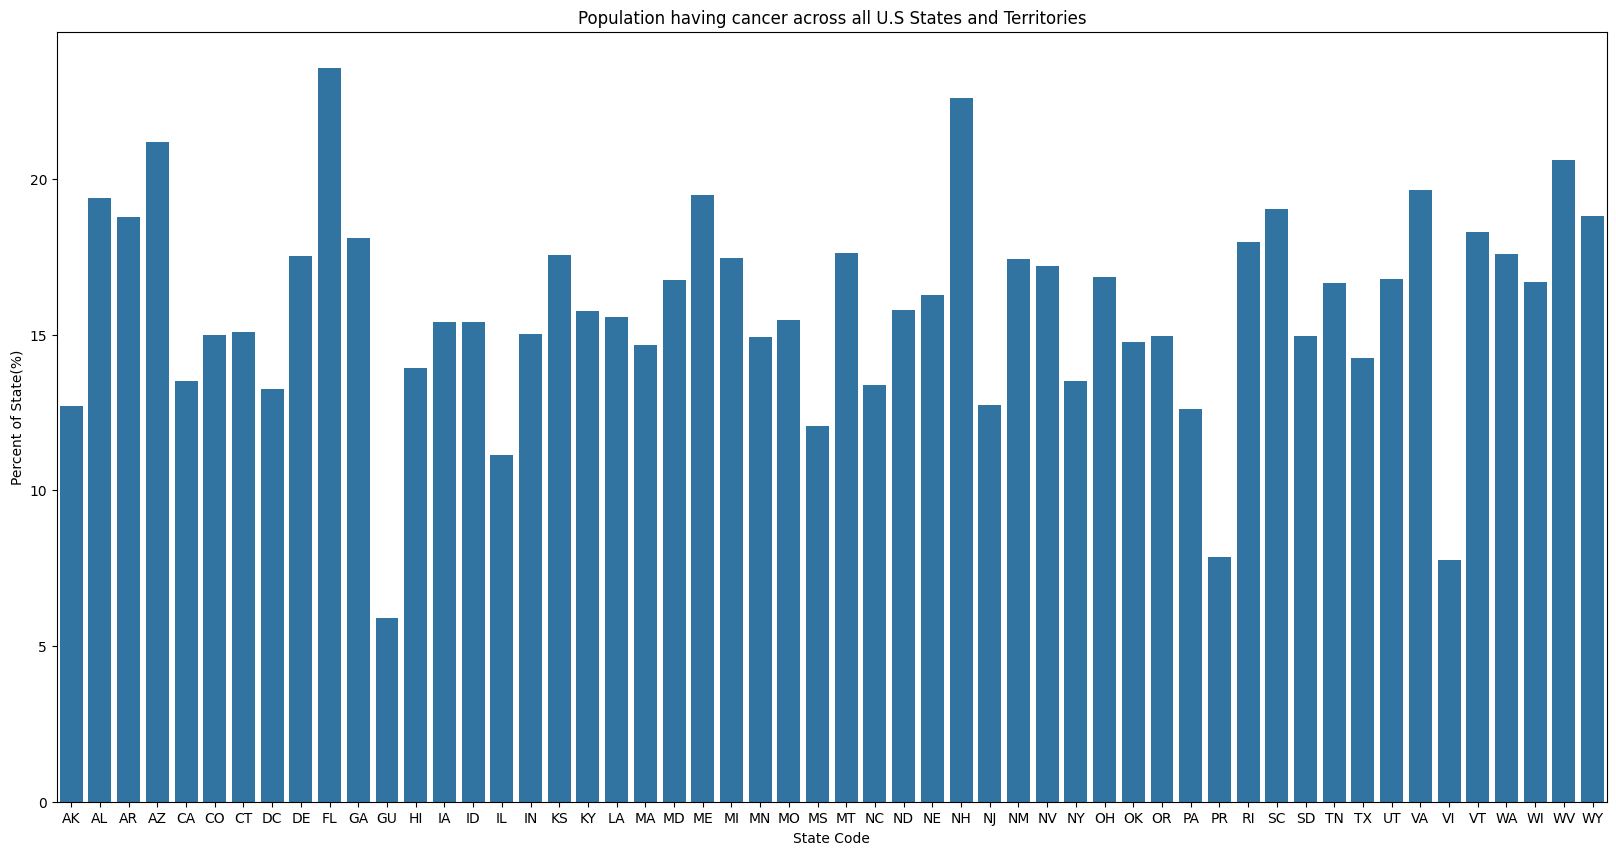

In [17]:
cancer_df = eda_df[eda_df['HAS_CANCER'] == "Yes"]
state_counts = cancer_df['STATE_CODE'].value_counts()
total_counts = eda_df['STATE_CODE'].value_counts()
percentage_df = (state_counts / total_counts * 100).reset_index()
percentage_df.columns = ['STATE_CODE', 'Percentage']
plt.figure(figsize=(20, 10))
sns.barplot(x='STATE_CODE', y='Percentage', data=percentage_df)
plt.title('Population having cancer across all U.S States and Territories')
plt.xlabel('State Code')
plt.ylabel('Percent of State(%)')
plt.show()

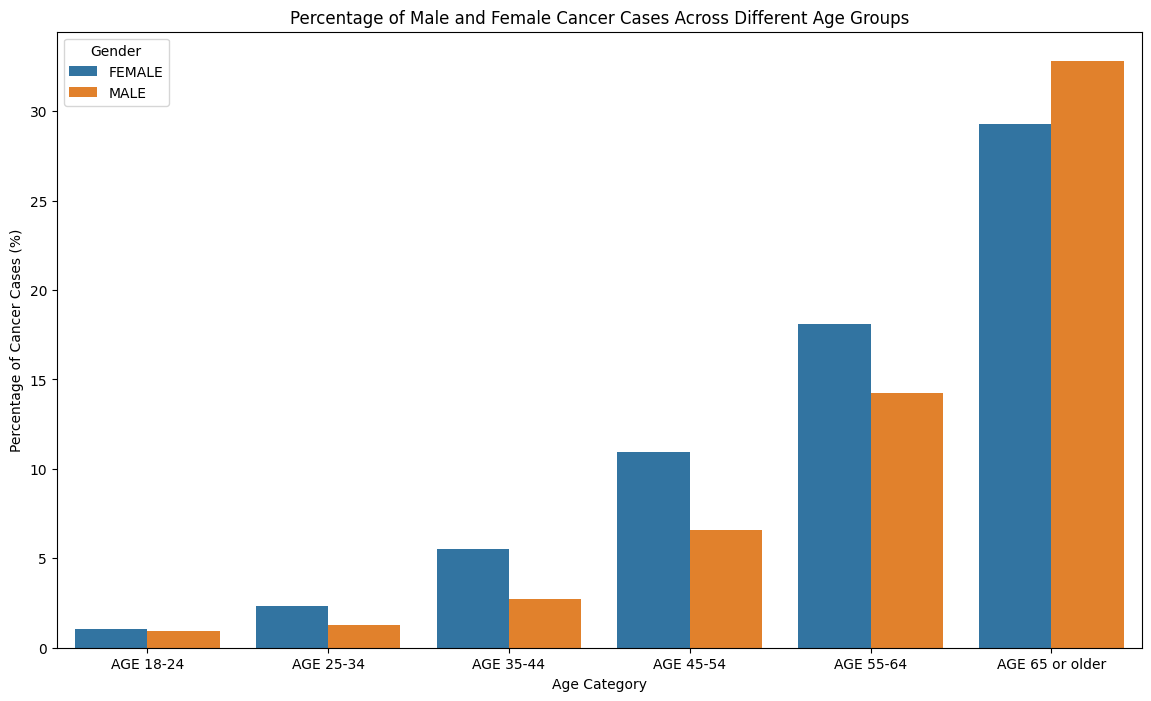

In [18]:
total_counts = eda_df.groupby(['AGE_CATEGORY', 'GENDER']).size().reset_index(name='Total_Count')
cancer_counts = cancer_df.groupby(['AGE_CATEGORY', 'GENDER']).size().reset_index(name='Cancer_Count')
merged_df = pd.merge(cancer_counts, total_counts, on=['AGE_CATEGORY', 'GENDER'])
merged_df['Percentage'] = (merged_df['Cancer_Count'] / merged_df['Total_Count']) * 100
plt.figure(figsize=(14, 8))
sns.barplot(data=merged_df, x='AGE_CATEGORY', y='Percentage', hue='GENDER')
plt.title('Percentage of Male and Female Cancer Cases Across Different Age Groups')
plt.xlabel('Age Category')
plt.ylabel('Percentage of Cancer Cases (%)')
plt.legend(title='Gender')
plt.show()

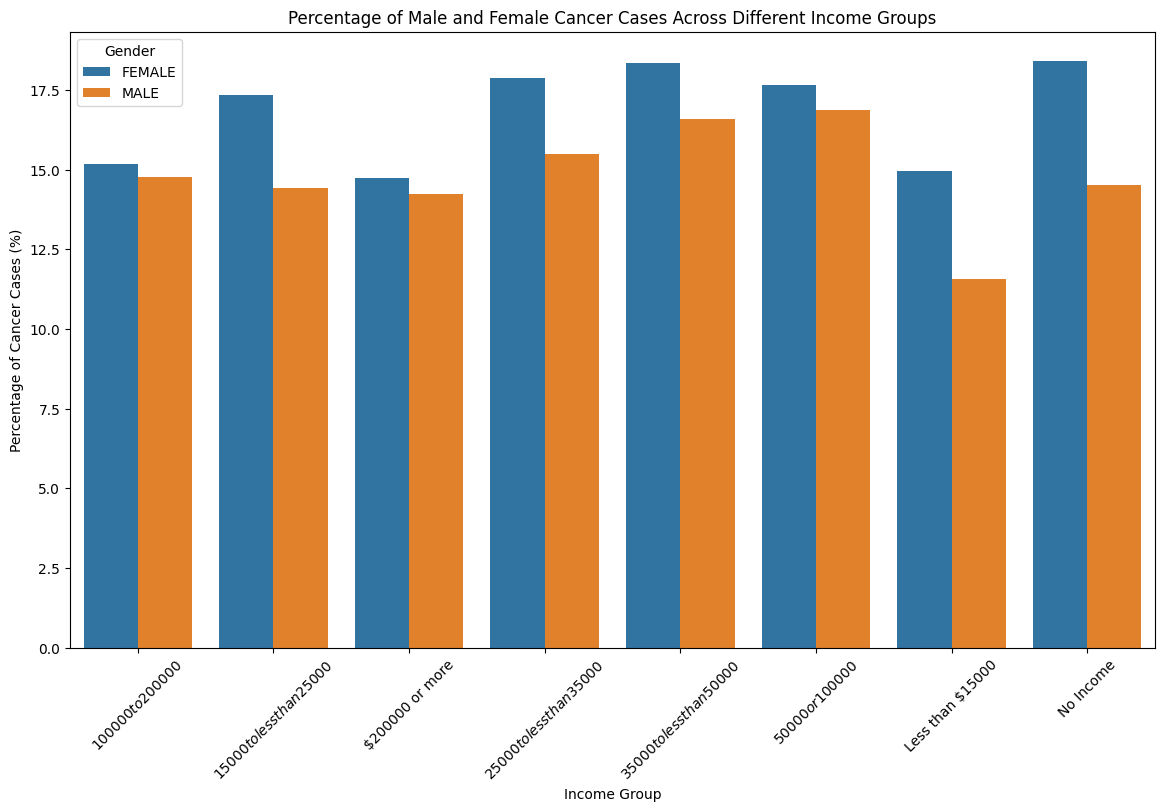

In [19]:
total_counts = eda_df.groupby(['INCOME_GRP', 'GENDER']).size().reset_index(name='Total_Count')
cancer_counts = cancer_df.groupby(['INCOME_GRP', 'GENDER']).size().reset_index(name='Cancer_Count')
merged_df = pd.merge(cancer_counts, total_counts, on=['INCOME_GRP', 'GENDER'])
merged_df['Percentage'] = (merged_df['Cancer_Count'] / merged_df['Total_Count']) * 100
plt.figure(figsize=(14, 8))
sns.barplot(data=merged_df, x='INCOME_GRP', y='Percentage', hue='GENDER')
plt.title('Percentage of Male and Female Cancer Cases Across Different Income Groups')
plt.xlabel('Income Group')
plt.xticks(rotation=45)
plt.ylabel('Percentage of Cancer Cases (%)')
plt.legend(title='Gender')
plt.show()

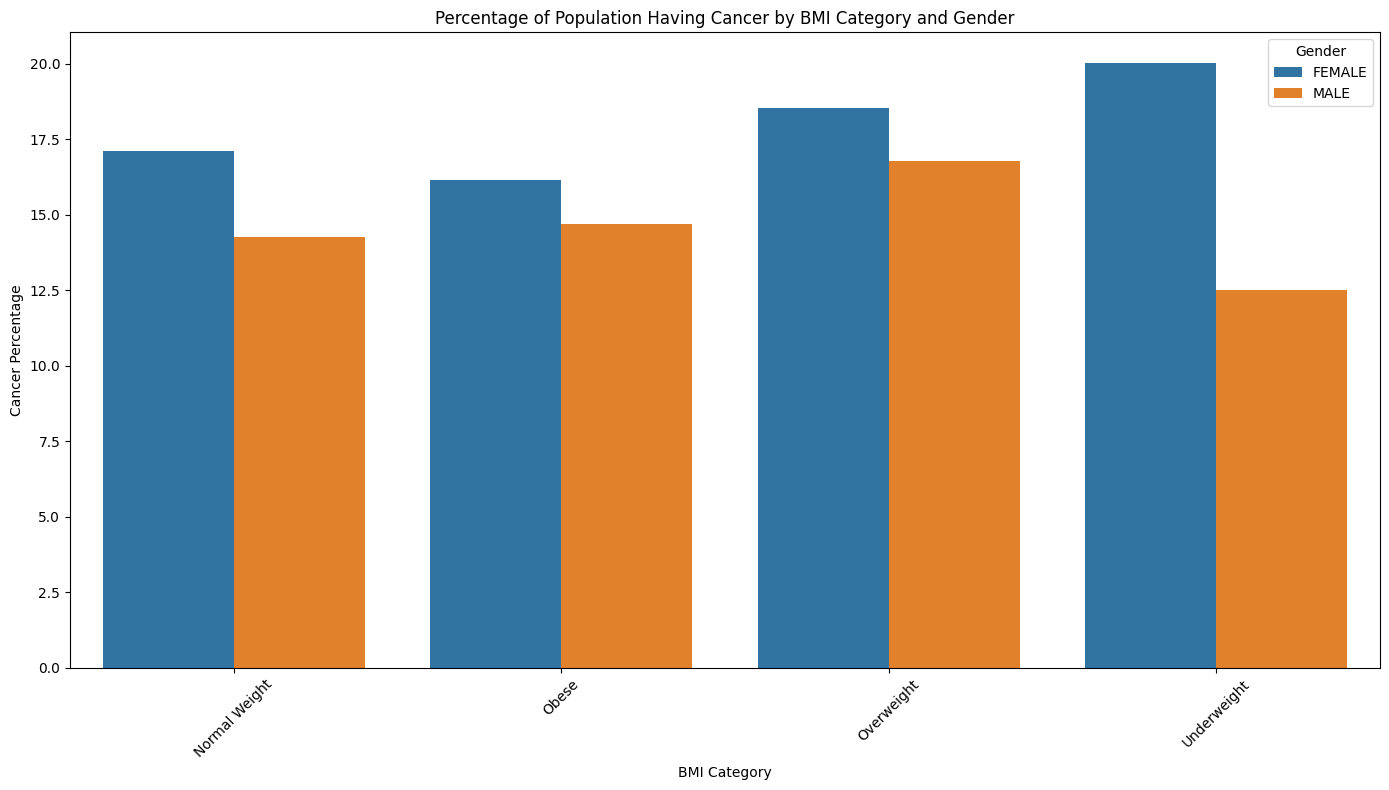

In [20]:

total_counts = eda_df.groupby(['BMI_CATEGORY', 'GENDER']).size().reset_index(name='Total_Count')
cancer_counts = cancer_df.groupby(['BMI_CATEGORY', 'GENDER']).size().reset_index(name='Cancer_Count')
merged_df = pd.merge(cancer_counts, total_counts, on=['BMI_CATEGORY', 'GENDER'])
merged_df['Percentage'] = (merged_df['Cancer_Count'] / merged_df['Total_Count']) * 100
plt.figure(figsize=(14, 8))
sns.barplot(data=merged_df, x='BMI_CATEGORY', y='Percentage', hue='GENDER')
plt.title('Percentage of Population Having Cancer by BMI Category and Gender')
plt.xlabel('BMI Category')
plt.ylabel('Cancer Percentage')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

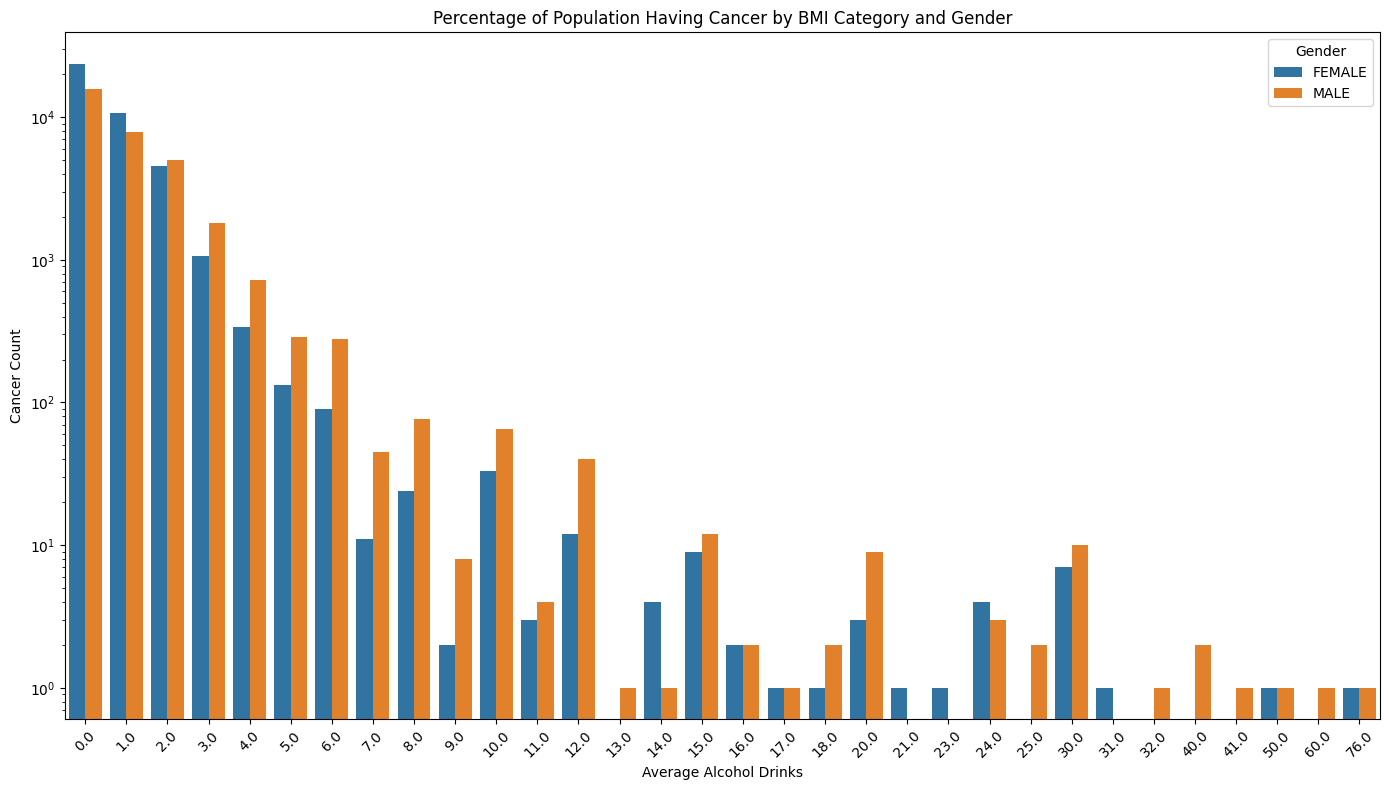

In [21]:
total_counts = eda_df.groupby(['ACG_ALC', 'GENDER']).size().reset_index(name='Total_Count')
cancer_counts = cancer_df.groupby(['ACG_ALC', 'GENDER']).size().reset_index(name='Cancer_Count')
plt.figure(figsize=(14, 8))
sns.barplot(data=cancer_counts, x='ACG_ALC', y='Cancer_Count', hue='GENDER')
plt.title('Percentage of Population Having Cancer by BMI Category and Gender')
plt.xlabel('Average Alcohol Drinks')
plt.ylabel('Cancer Count')
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

In [22]:
eda_df = eda_df.drop(columns=["YEAR", "MONTH", "DAY", "YEARMO"])

Plotting a Correlation Matrix to explain the relationships between each variable

In [23]:
import scipy.stats as ss
import numpy as np

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

corr_matrix = pd.DataFrame({col: [cramers_v(eda_df[col], eda_df[col2]) for col2 in eda_df.columns] for col in eda_df.columns}, index=eda_df.columns)

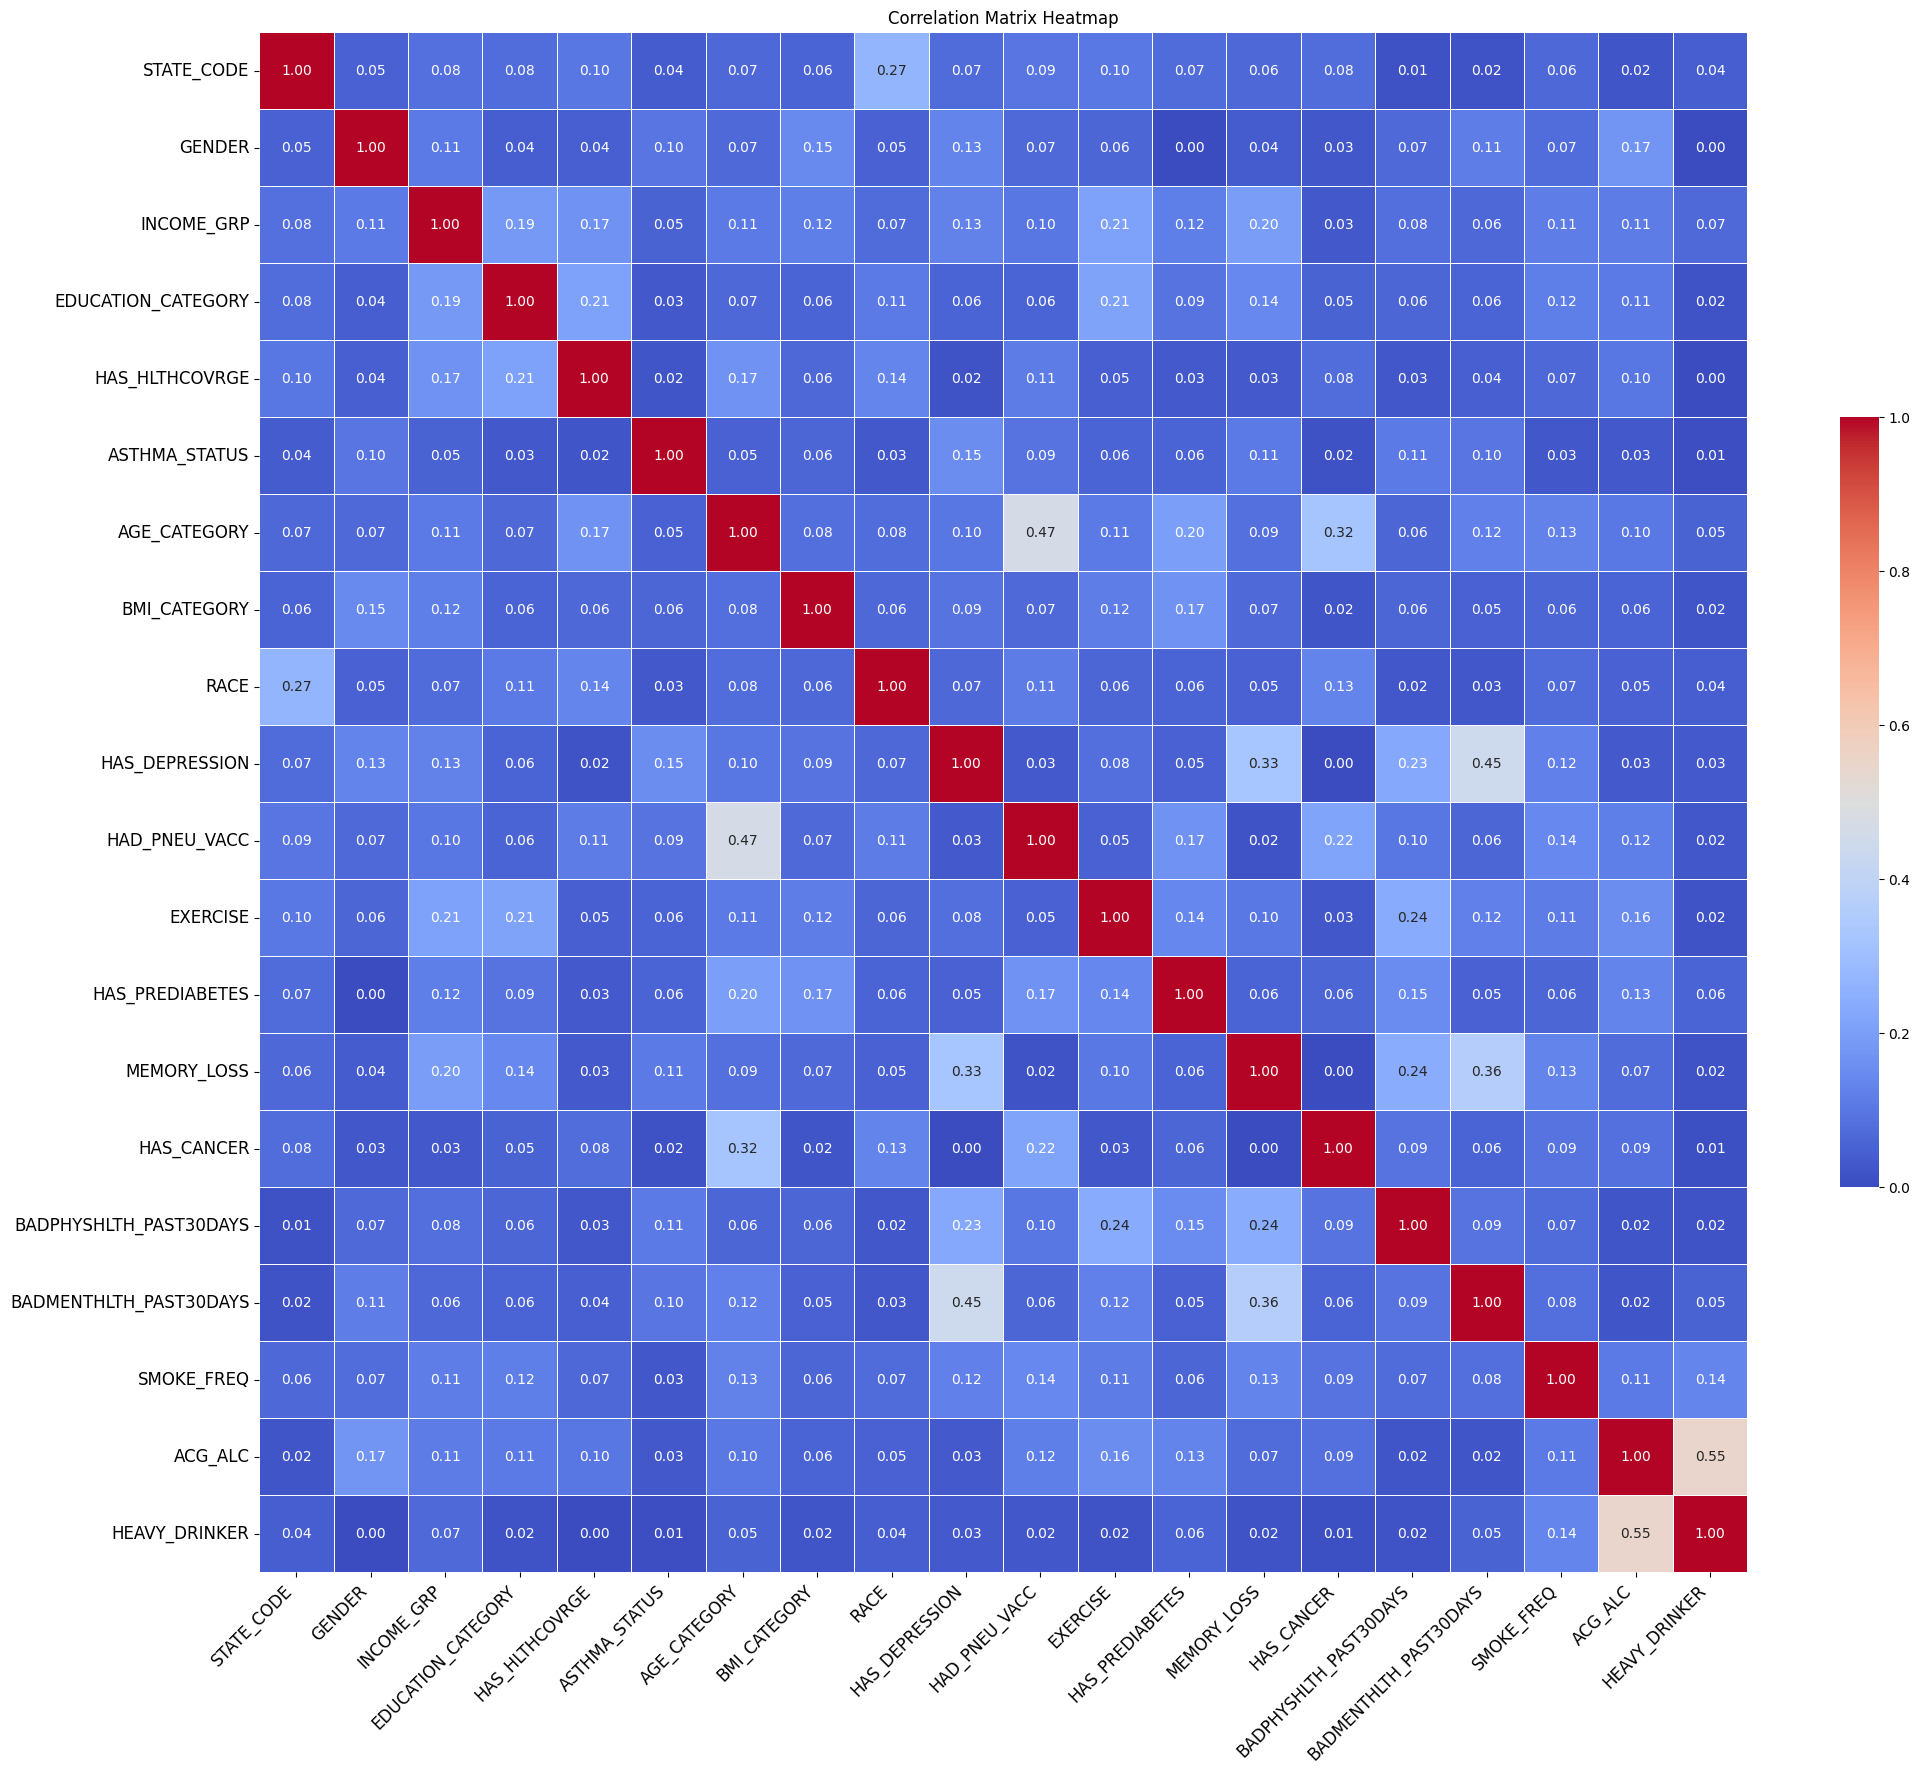

In [24]:
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, cbar_kws={'shrink': 0.5}, annot_kws={"size": 10})
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

Encoding the ordinal features manually to maintain the order of relation between each value.

In [25]:
ordinal_mappings = {
    'EDUCATION_CATEGORY': {
        'Never attended school' : 0,
        'Grades 1 through 8' : 1,
        'Grades 9 through 11' : 2,
        'Grades 12 or High School Graduate' : 3,
        'College 1 year to 3 years' : 4,
        'College 4 years or more' : 5
    },
    'INCOME_GRP': {
        'No Income': 0,
        'Less than $15000' : 1,
        '$15000 to less than $25000' : 2,
        '$25000 to less than $35000' : 3,
        '$35000 to less than $50000' : 4,
        '$50000 or $100000' : 5,
        '$100000 to $200000' : 6,
        '$200000 or more' : 7
    },
    'HAS_HLTHCOVRGE' : {
        'No' : 0,
        'Yes' : 1
    },
    'ASTHMA_STATUS' : {
        'Never' : 0,
        'Former' : 1,
        'Current' : 2
    },
    'AGE_CATEGORY' : {
        'AGE 18-24' : 0,
        'AGE 25-34' : 1,
        'AGE 35-44' : 2,
        'AGE 45-54' : 3,
        'AGE 55-64' : 4,
        'AGE 65 or older' : 5
    },
    'BMI_CATEGORY' : {
        'Underweight' : 0,
        'Normal Weight' : 1,
        'Overweight' : 2,
        'Obese' : 3
    },
    'HAS_DEPRESSION' : {
        'No' : 0,
        'Yes' : 1
    },
    'HAD_PNEU_VACC' : {
        'No' : 0,
        'Yes' : 1
    },
    'EXERCISE' : {
        'No' : 0,
        'Yes' : 1
    },
    'HAS_PREDIABETES' : {
        'No' : 0,
        'Yes' : 1
    },
    'MEMORY_LOSS' : {
        'No' : 0,
        'Yes' : 1
    },
    'SMOKE_FREQ' : {
        'No' : 0,
        'Low' : 1,
        'Medium' : 2,
        'High' : 3
    },
    'HAS_CANCER' : {
        'No' : 0,
        'Yes' : 1
    },
    'HEAVY_DRINKER' : {
        'No' : 0,
        'Yes' : 1
    }
}

for col, mapping in ordinal_mappings.items():
    eda_df[col] = eda_df[col].map(mapping).astype(int)

In [26]:
eda_df

,STATE_CODE,GENDER,INCOME_GRP,EDUCATION_CATEGORY,HAS_HLTHCOVRGE,ASTHMA_STATUS,AGE_CATEGORY,BMI_CATEGORY,RACE,HAS_DEPRESSION,HAD_PNEU_VACC,EXERCISE,HAS_PREDIABETES,MEMORY_LOSS,HAS_CANCER,BADPHYSHLTH_PAST30DAYS,BADMENTHLTH_PAST30DAYS,SMOKE_FREQ,ACG_ALC,HEAVY_DRINKER
0,AL,FEMALE,0,5,0,0,5,1,White,0,0,0,1,0,0,0,0,0,0.0,0
1,AL,FEMALE,3,3,1,0,5,2,White,0,0,0,0,0,1,0,0,0,0.0,0
2,AL,FEMALE,6,5,1,0,4,2,White,0,0,1,0,0,1,2,3,0,0.0,0
3,AL,FEMALE,0,3,0,2,5,1,White,0,1,1,0,0,0,0,0,2,0.0,0
4,AL,FEMALE,3,4,1,0,2,1,White,0,1,1,0,0,0,2,0,0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445127,VI,FEMALE,1,3,1,2,0,2,African American,1,0,1,0,0,0,0,3,0,0.0,0
445128,VI,FEMALE,5,5,1,0,3,2,African American,0,0,1,0,0,0,2,2,0,0.0,0
445129,VI,FEMALE,0,3,0,0,5,0,Other Race,0,0,0,0,0,0,30,30,3,0.0,0
445130,VI,MALE,5,4,1,1,5,3,African American,0,1,0,0,0,0,0,0,0,0.0,0


Splitting the data into Feature dataframe and target dataframe for further processing.

In [27]:
X = eda_df[eda_df.columns.difference(['HAS_CANCER'])]
y = eda_df['HAS_CANCER']

In [28]:
y.value_counts()

HAS_CANCER
0    372332
1     72800
Name: count, dtype: int64

Encoding and Scaling the Categorical and Numerical data respectively using OneHotEncoder and StandardScaler

In [29]:
categorical_columns = ['GENDER','RACE','STATE_CODE']
numerical_columns = ['BADPHYSHLTH_PAST30DAYS', 'BADMENTHLTH_PAST30DAYS', 'ACG_ALC']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_preprocessed = pipeline.fit_transform(X)

Plotting a graph to visualize the variance explained by each component. It helps in determining the number of components that are useful to explain 90% of variance and reduce the number of dimensions used to train the data.

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [90.0%] explained variance using the [63] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [26] that covers the [90.00%] explained variance.
[pca] >The PCA reduction is performed on the [63] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[26]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


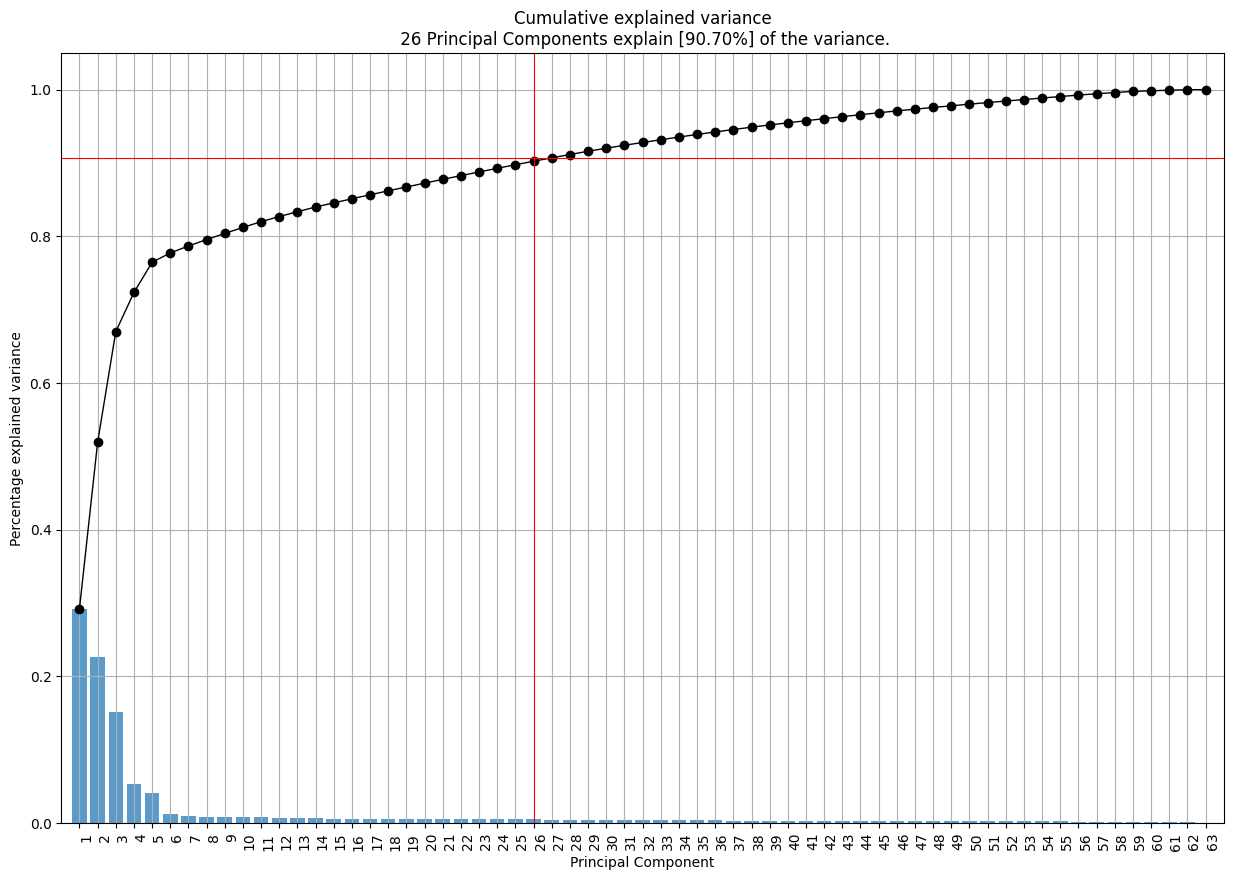

In [30]:
from pca import pca

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

X_pca_df = pd.DataFrame(X_preprocessed.toarray(), columns=feature_names)

pca_model = pca(n_components=0.9)
results = pca_model.fit_transform(X_pca_df)

fig, ax = pca_model.plot()

Splitting the data into training and testing sets with only 26 components which were used to explain 90% variance of the data. It reduced the number of components significantly and reduced the time to train the models.

In [31]:
n_components = 26
X_pca = results["PC"]
y = eda_df['HAS_CANCER']

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

Listing all the models as dictionary objects to evaluate all of them at once

In [32]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'CatBoost' : CatBoostClassifier(random_state=42, eval_metric='Logloss', verbose=0),
    'Decision Tree' : DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
}

A simple function that helps to evaluate the metrics of any model and displays the confusion matrix to understand the balance of the predictions.

In [33]:
def evaluate_model(y_test, y_pred, model_name, disease_name):
    print(f"{model_name} - Precision: {precision_score(y_test, y_pred, average='weighted')}")
    print(f"{model_name} - Recall: {recall_score(y_test, y_pred, average='weighted')}")
    print(f"{model_name} - Classification Report:\n {classification_report(y_test, y_pred)}")
    print(f"{model_name} - Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}\n")
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    print(f"{model_name} - Confusion Matrix (Percentages):\n {cm_percent}\n")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=["None", disease_name])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix (Percentages)')
    plt.show()

Running the pipeline to train all the models and evaluating them based on the results

Cancer Prediction
Logistic Regression - Precision: 0.7829015050162619
Logistic Regression - Recall: 0.5181798780145349
Logistic Regression - Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.48      0.63     74467
           1       0.21      0.71      0.33     14560

    accuracy                           0.52     89027
   macro avg       0.55      0.60      0.48     89027
weighted avg       0.78      0.52      0.58     89027

Logistic Regression - Confusion Matrix:
 [[35783 38684]
 [ 4211 10349]]

Logistic Regression - Confusion Matrix (Percentages):
 [[48.05215733 51.94784267]
 [28.9217033  71.0782967 ]]



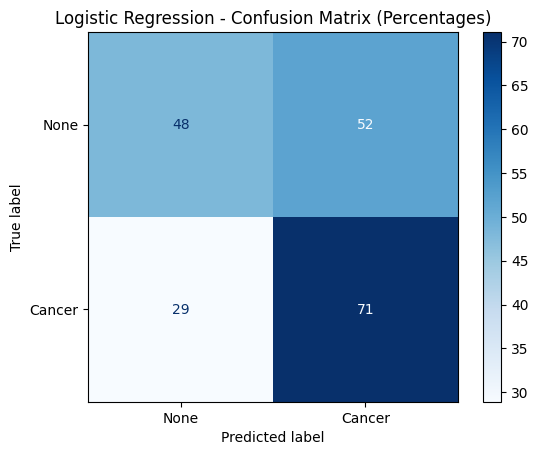

XGBoost - Precision: 0.7808634160507484
XGBoost - Recall: 0.5761847529401193
XGBoost - Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.56      0.69     74467
           1       0.22      0.64      0.33     14560

    accuracy                           0.58     89027
   macro avg       0.56      0.60      0.51     89027
weighted avg       0.78      0.58      0.63     89027

XGBoost - Confusion Matrix:
 [[41927 32540]
 [ 5191  9369]]

XGBoost - Confusion Matrix (Percentages):
 [[56.30279184 43.69720816]
 [35.65247253 64.34752747]]



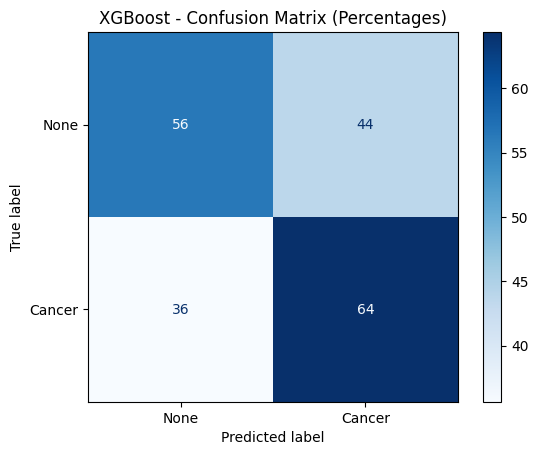

CatBoost - Precision: 0.7774804846003465
CatBoost - Recall: 0.5987734058207062
CatBoost - Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.60      0.71     74467
           1       0.23      0.60      0.33     14560

    accuracy                           0.60     89027
   macro avg       0.56      0.60      0.52     89027
weighted avg       0.78      0.60      0.65     89027

CatBoost - Confusion Matrix:
 [[44524 29943]
 [ 5777  8783]]

CatBoost - Confusion Matrix (Percentages):
 [[59.79024266 40.20975734]
 [39.6771978  60.3228022 ]]



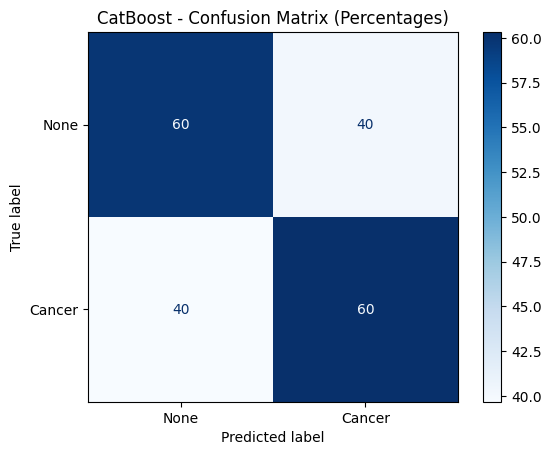

Decision Tree - Precision: 0.7636145936209066
Decision Tree - Recall: 0.611084277803363
Decision Tree - Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.63      0.73     74467
           1       0.22      0.52      0.31     14560

    accuracy                           0.61     89027
   macro avg       0.54      0.58      0.52     89027
weighted avg       0.76      0.61      0.66     89027

Decision Tree - Confusion Matrix:
 [[46789 27678]
 [ 6946  7614]]

Decision Tree - Confusion Matrix (Percentages):
 [[62.83185841 37.16814159]
 [47.70604396 52.29395604]]



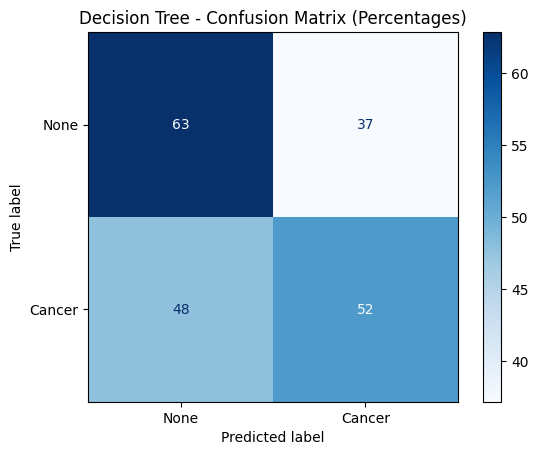

Random Forest - Precision: 0.7649273851669998
Random Forest - Recall: 0.6123310905680299
Random Forest - Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.63      0.73     74467
           1       0.22      0.53      0.31     14560

    accuracy                           0.61     89027
   macro avg       0.54      0.58      0.52     89027
weighted avg       0.76      0.61      0.66     89027

Random Forest - Confusion Matrix:
 [[46831 27636]
 [ 6877  7683]]

Random Forest - Confusion Matrix (Percentages):
 [[62.88825923 37.11174077]
 [47.23214286 52.76785714]]



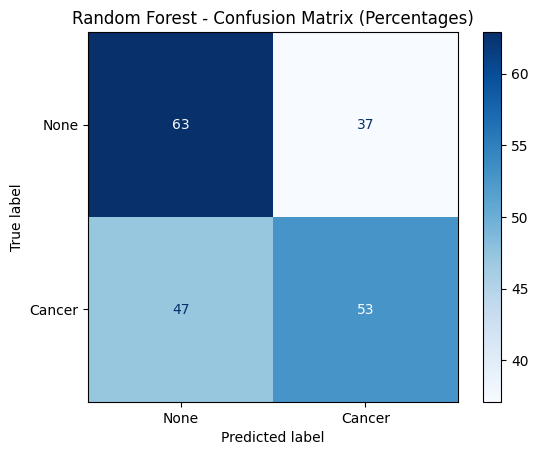

In [34]:
print("Cancer Prediction")
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model(y_test, y_pred, model_name, "Cancer")

In [38]:
X_train

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26
0,-0.692410,-0.082923,-0.016504,0.504605,-0.188684,-0.039680,-0.009549,-0.008409,-0.007974,-0.005447,...,-0.010118,0.003469,-0.006541,-0.001680,-0.018425,-0.001689,-0.001172,0.007618,0.012244,0.012344
1,-0.681449,-0.583484,-0.113357,0.447972,-0.171224,-0.056723,-0.038211,-0.024216,-0.008040,0.009673,...,-0.485120,0.755614,-0.085709,0.027332,0.216168,-0.016395,0.005093,-0.054051,-0.020086,-0.057795
2,0.142938,0.599961,-0.749873,0.487656,-0.190103,-0.057783,0.002369,-0.023436,-0.014907,-0.011660,...,-0.052421,-0.074167,-0.066059,-0.066491,-0.135062,-0.540087,-0.510870,-0.371484,-0.397916,-0.103892
3,-0.692012,-0.084209,-0.017087,0.506927,-0.183357,-0.042317,0.003976,-0.011301,-0.008063,-0.004690,...,-0.015046,0.000426,0.001287,0.005069,-0.020040,-0.014045,0.000923,0.006799,0.017990,0.025762
4,-0.705012,0.419686,0.078994,0.554244,-0.185392,-0.041282,-0.003896,-0.008711,-0.009024,-0.007015,...,-0.010355,0.001253,-0.011465,-0.000227,-0.018673,-0.003356,0.010949,0.012175,0.017697,0.010190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595725,-0.693402,-0.083144,-0.017580,0.502967,-0.189595,-0.055932,-0.018364,-0.017582,-0.015013,-0.006891,...,-0.056720,-0.096066,-0.060970,-0.070560,-0.121940,-0.173027,-0.192728,-0.068413,0.838135,-0.275052
595726,1.330672,-0.837984,1.972918,-0.528324,-0.247147,-0.050095,0.007768,-0.005775,-0.002657,-0.011999,...,-0.000507,-0.004430,-0.006256,-0.023165,-0.023794,-0.014470,-0.006360,-0.033265,-0.028803,-0.016208
595727,0.265196,-0.661340,0.920198,-0.532039,-0.254370,-0.046514,0.007820,-0.007911,-0.002904,-0.010907,...,-0.006803,0.001555,-0.005595,-0.000765,-0.017466,-0.003318,0.042945,0.019526,0.044186,0.038970
595728,0.632163,-0.478655,-0.481794,0.386286,-0.226616,0.945857,-0.034005,0.021390,0.005711,-0.008394,...,0.001566,0.013343,-0.001948,0.000880,0.008292,-0.002252,-0.000857,-0.005336,-0.000485,-0.002831


Lime Tabular Explainer is a library that helps you to visualize the factors that responsible for prediction of each data point.

In [46]:
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out()[:26],
    class_names=["None", "HAS_CANCER"],
    mode='classification',
    random_state=42
)

i = 10000
instance = np.array(X_test)[i]
actual_label = y_test.values[i]
predicted_label = models["CatBoost"].predict([instance])[0]


print(f"Actual label: {actual_label}")
print(f"Predicted label: {predicted_label}")
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn= models["CatBoost"].predict_proba,
    num_features=10
)

exp.show_in_notebook(show_table=True, show_all=True)


Actual label: 1
Predicted label: 1


Performing a grid search using catboost classifier to tune the hyper parameters

In [48]:
param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6, 10],
    'learning_rate': [0.01, 0.1]
}

cb = CatBoostClassifier(random_state=42, eval_metric='Logloss', verbose=0)

grid_search = GridSearchCV(estimator=cb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'depth': 10, 'iterations': 200, 'learning_rate': 0.1}
Best Score: 0.6632467922510951


GridSearch - Catboost - Precision: 0.7805342533282227
GridSearch - Catboost - Recall: 0.5857548833499949
GridSearch - Catboost - Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.58      0.70     74467
           1       0.23      0.63      0.33     14560

    accuracy                           0.59     89027
   macro avg       0.56      0.60      0.52     89027
weighted avg       0.78      0.59      0.64     89027

GridSearch - Catboost - Confusion Matrix:
 [[42952 31515]
 [ 5364  9196]]

GridSearch - Catboost - Confusion Matrix (Percentages):
 [[57.67924047 42.32075953]
 [36.84065934 63.15934066]]



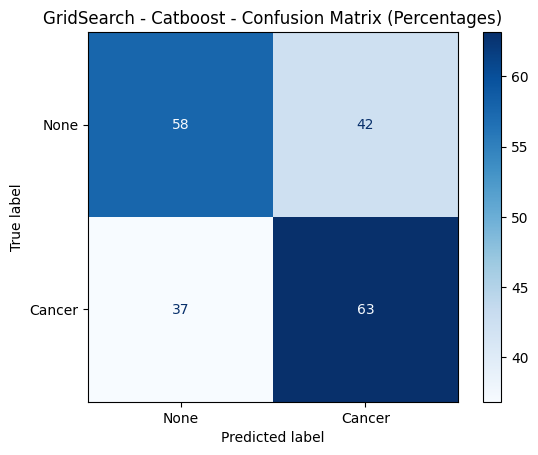

In [49]:
y_pred_cb = grid_search.best_estimator_.predict(X_test)
evaluate_model(y_test, y_pred_cb, "GridSearch - Catboost", "Cancer")

The Accuracy is less than what we got previously. Hence we assume that the previous model is the best for given data.